In [ ]:
# import required packages
from fastai.tabular.all import *
from matplotlib import style
from helpers import *

In [8]:
# path to project directory
path = Path('./')

In [25]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v5.csv', index_col=0, dtype={'season':str})

## Neural network model

Fastai have useful a neural network architecture that can be applied to tabular data, including for time series. In practice this creates embeddings for categorical features, combines them with continuous variables and passes this through a number of fully connected layers to produce a prediction for the dependent variable. They also include a number of tricks and default parameters that should produce decent performance.

Lag features are not strictly necessary for this approach since the embeddings should in some way be relating performance for recent weeks. In practice this seems to be confirmed in that adding the lag features does not appear to improve performance. However, we'll still create some features to remain consistent in the steps we take in all of these notebooks.

In [12]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

Again we set the variables to be used, the validation conditions, and order of some categorical features. We also need to set our dependent variable, total_points, to be a floating point number since this is the data type that fastai requires for a regression model.

In [13]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 1
valid_len = 6
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [14]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

In [15]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [16]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [17]:
# create dataset with adjusted post-validation lag numbers
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

In [18]:
# take a look at the dataframe
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71132 entries, 0 to 71131
Data columns (total 39 columns):
gw                                            71132 non-null category
minutes                                       71132 non-null int64
minutes_last_1                                71132 non-null float64
minutes_last_10                               71132 non-null float64
minutes_last_2                                71132 non-null float64
minutes_last_3                                71132 non-null float64
minutes_last_4                                71132 non-null float64
minutes_last_5                                71132 non-null float64
minutes_last_all                              71132 non-null float64
opponent_team                                 71132 non-null object
player                                        71132 non-null object
position                                      71132 non-null int64
relative_market_value_opponent_team_season    71132 non-null float64

We need to create a couple of lists with indexes for the training and validation sets - this can then be passed into the learner object which will handle training and validation automatically.

In [20]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(67936, 71132)

A key difference with this approach is that we will be learning embeddings for all the categorical variables, including players. So, for example, we will learn a vector of numbers for each player that represents them. In theory, this negates the need for the kind of feature engineering that, for example, we are doing when calculating lagging features.

In previous approaches we did not use the player as a categorical feature, there were simply too many of them. So we will need to add this feature in, which we can do by simply adding them to the list of categorical features.

We can also have a quick look at how many levels there are for each of the categories - fastai creates a default lenght for each of these variables based on the number of levels (but note that this default can be changed if so desired).

In [21]:
train_valid_df[cat_vars + ['player']].nunique()

gw                 38
season              4
position            4
team               29
opponent_team      29
was_home            2
player           1211
dtype: int64

In [13]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

Now we can instantiate our tabular object, including processors to handle some transformations we need to apply (handling the categorical features and normalising continuous variables to have a mean and standard deviation that help training). 

In [ ]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

The fastai requires us to create dataloaders that will then be used for training. We can do this and then take a look at one batch.

In [16]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [17]:
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points
0,28,1718,4,Tottenham Hotspur,Crystal Palace,False,Fernando_Llorente,3.971288e-07,1.751141,0.635984,0.0
1,11,1819,2,Huddersfield Town,Fulham,True,Mathias_Jorgensen,9.000000e+01,0.273778,0.405284,8.0
2,26,1617,1,Stoke City,Tottenham Hotspur,False,Jack_Butland,3.971288e-07,0.718705,1.433690,0.0
3,29,1718,1,Arsenal,Brighton and Hove Albion,False,Petr_Cech,9.000000e+01,2.073500,0.349181,2.0
4,17,1617,2,Sunderland,Watford,True,Patrick_van Aanholt,9.000000e+01,0.418392,0.704200,15.0
5,12,1718,2,Swansea City,Burnley,False,Kyle_Naughton,9.000000e+01,0.560457,0.316798,1.0
6,14,1617,3,Tottenham Hotspur,Swansea City,True,Christian_Eriksen,9.000000e+01,1.433690,0.509881,18.0
7,2,1617,2,Manchester City,Stoke City,False,Eliaquim_Mangala,3.971288e-07,2.311012,0.718705,0.0
8,16,1819,3,Newcastle United,Wolverhampton Wanderers,True,Christian_Atsu,8.800000e+01,0.483921,0.388177,2.0
9,28,1819,4,Burnley,Newcastle United,False,Sam_Vokes,3.971288e-07,0.449442,0.483921,0.0


We also need to provide the range of output points that we expect - we set these to the highest score recorded in history at the upper end, and -1 at the lower end.

In [18]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

Now we can instatiate the learner and use the learning rate finder to get a feel for the best learning rate to use during training.

In [19]:
learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0014454397605732083)

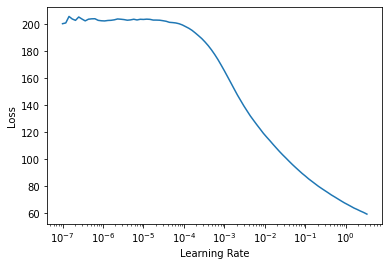

In [20]:
learn.lr_find()

Finally, we can fit the training data using one cycle learning and look at the performance.

In [21]:
# seems to work ok without the lag vars
learn.fit_one_cycle(7, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,3.991505,4.984871,2.232682,00:12
1,3.961542,4.329923,2.080847,00:12
2,3.647326,4.893950,2.212228,00:12
3,3.392024,3.890459,1.972425,00:12
4,3.599243,3.904349,1.975942,00:13
5,3.205671,3.714007,1.927176,00:12
6,3.218670,3.690068,1.920955,00:12


In [22]:
# check that rmse matches the training output above
preds,targs = learn.get_preds()
r_mse(preds,targs)

1.920955

get_preds() returns tensors which don't work for our existing mean absolute error function, so we'll create a slightly different function that works in this case.

In [24]:
def mae_tensor(pred,y): return round((abs(pred-y)).mean().item(), 6)

In [44]:
mae_tensor(preds,targs)

1.086671

This actually looks to be worse than both random forest and XGBoost, but let's go ahead and run it across the whole season it see if that is consistently the case.

In [49]:
def nn_season(df, valid_season='1920'):

    # empty list for scores
    scores = []
    valid_len = 6

    # set limits
    max_y = np.max(df['total_points'])
    min_y = np.min(df['total_points'])
    y_range = (-1, max_y)

    for valid_gw in range(1,34): 

        train_valid_df, train_idx, valid_idx = create_lag_train(df, cat_vars, cont_vars, 
                                                        player_lag_vars, team_lag_vars, dep_var,
                                                        valid_season, valid_gw, valid_len)

        X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

        # create train/valid splits
        splits = (list(train_idx), list(valid_idx))

        # processors - categorify categorical variables and normalize continuous variables
        # fill missing not used because new teams are almost certainly well below the league average
        procs=[Categorify, Normalize]
        to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                              splits=splits, y_names=dep_var)

        dls = to_nn.dataloaders()

        learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                            n_out=1, loss_func=F.mse_loss, metrics=rmse)

        # seems to work ok without the lag vars
        with learn.no_bar() and learn.no_logging():
            learn.fit_one_cycle(7, 1e-2, wd=0.2, verbose=False)

        preds,targs = learn.get_preds()
        gw_mae = mae_tensor(preds,targs)

        print("GW%d MAE: %f" % (valid_gw, gw_mae))

        scores.append(gw_mae)
        
    return scores

In [50]:
scores = nn_season(lag_train_df)

GW1 MAE: 1.052098


GW2 MAE: 1.026132


GW3 MAE: 1.060525


GW4 MAE: 1.050153


GW5 MAE: 1.060475


GW6 MAE: 1.059864


GW7 MAE: 1.022981


GW8 MAE: 1.024074


GW9 MAE: 1.027962


GW10 MAE: 1.039557


GW11 MAE: 0.999333


GW12 MAE: 0.986778


GW13 MAE: 0.986875


GW14 MAE: 0.976821


GW15 MAE: 0.959809


GW16 MAE: 0.973564


GW17 MAE: 0.943456


GW18 MAE: 0.896393


GW19 MAE: 0.910562


GW20 MAE: 0.931715


GW21 MAE: 0.916993


GW22 MAE: 0.896387


GW23 MAE: 0.886316


GW24 MAE: 0.926095


GW25 MAE: 0.894810


GW26 MAE: 0.864132


GW27 MAE: 0.918989


GW28 MAE: 0.892087


GW29 MAE: 0.883615


GW30 MAE: 0.921161


GW31 MAE: 0.875136


GW32 MAE: 0.862223


GW33 MAE: 0.869562


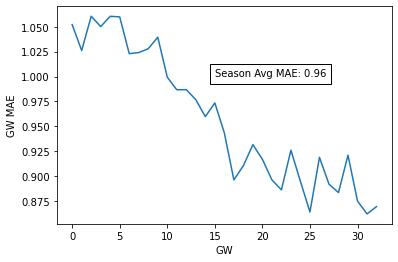

In [51]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

The performance does appear to be consistently worse across the season than the current iterations of both random forest and XGBoost, although it still outperforms the baseline model by a significant margin. In practice it may be that playing around with the model architecture, hyperparameters and feature selection could improve performance significantly.

Another challenge is that performance varies when repeating the training using the same data - this non-deterministic behaviour is not necessarily a big issue, but it can raise questions from users when they see seemingly unexplainable differences in player forecasts from week to week (or within week if retraining is performed for some reason).

Let's add this final model to our scores dataset.

In [9]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['neural_net'] = scores
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

In [10]:
# sort scores by reverse overall mean score
model_validation_scores = model_validation_scores.reindex(model_validation_scores.mean()
                                                          .sort_values().index[::-1],
                                                          axis=1)

In [13]:
style.use('fivethirtyeight')

And we can create a chart comparing all four approaches.

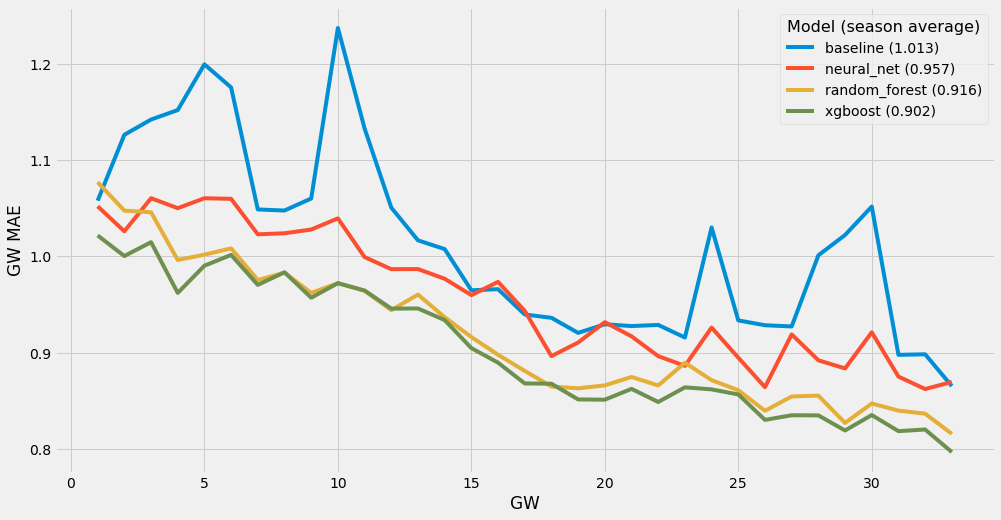

In [21]:
fig = plt.figure(figsize=(15, 8))

plt.plot(model_validation_scores)

legend_text = ['%s (%.3f)' %(model_validation_scores.columns[x], 
                             np.mean(model_validation_scores.iloc[:,x])) for x in range(4)]

plt.legend(legend_text, title='Model (season average)', title_fontsize='16')
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.show()

fig.savefig(path/'charts/comparison_chart.png')

So, based on performance and consistency, we will be using the XGBoost approach for our actual weekly forecasts. 